In [40]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import warnings
import tqdm
warnings.filterwarnings("ignore")

# LAB 1 creción de modelo de reconocimiento de autmóbiles en autopista

## Importación de imagenes y perimera visualización

Importamos las imagenes de la 1051 a la 1350, las importamos en escala de grises convertimos el array de imagenes en un numpy array

In [67]:
train = [cv2.imread(f'./highway/input/in00{i}.jpg', cv2.IMREAD_GRAYSCALE) for i in range(1050,1200)]
train_imgsGT = [cv2.imread(f'./highway/groundtruth/gt00{i}.png', cv2.IMREAD_GRAYSCALE)for i in range(1050, 1200)]

test = [cv2.imread(f'./highway/input/in00{i}.jpg', cv2.IMREAD_GRAYSCALE) for i in range(1200,1350)]
test_imgsGT = [cv2.imread(f'./highway/groundtruth/gt00{i}.png', cv2.IMREAD_GRAYSCALE)for i in range(1200, 1350)]

train_imgs = np.array(train)
train_imgs = train_imgs.astype(int)

train_imgsGT = np.array(train_imgsGT)
train_imgsGT = train_imgsGT.astype(int)


test_imgs = np.array(test)
test_imgs = test_imgs.astype(int)

test_imgsGT = np.array(test_imgsGT)
test_imgsGT = test_imgsGT.astype(int)


In [68]:
test_imgs.shape, test_imgsGT.shape, train_imgs.shape, train_imgsGT.shape

((150, 240, 320), (150, 240, 320), (150, 240, 320), (150, 240, 320))

Visualizacion de dos imagenes una de cada tipo de las que hemos importado, tanto la real como la que utilizaremos para evaluar el modelo

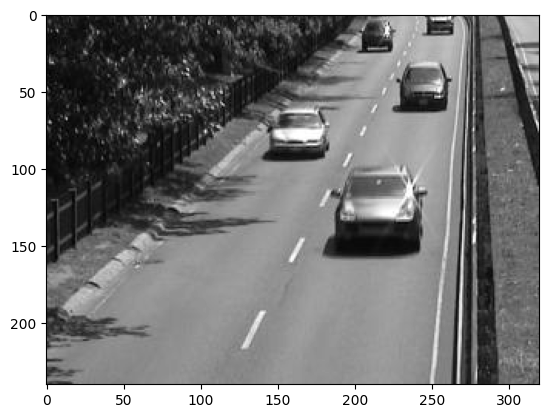

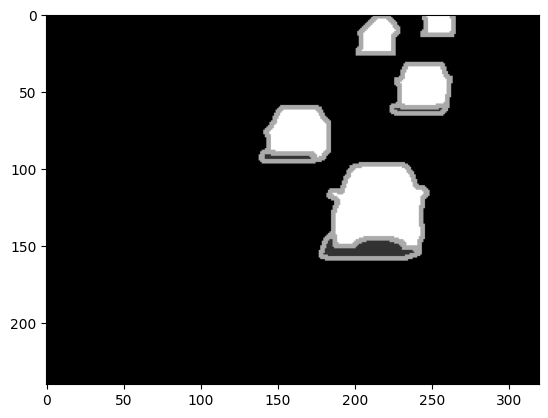

In [69]:
plt.imshow(train_imgs[0], cmap='gray')
plt.show()
plt.imshow(train_imgsGT[0], cmap='gray')
plt.show()

Imagen media y imagen desviación estandard de todo el conjunto de imagenes de entrenamiento

In [71]:
mean = np.mean(train_imgs, 0)
std = np.std(train_imgs, 0)

Visualización de las dos

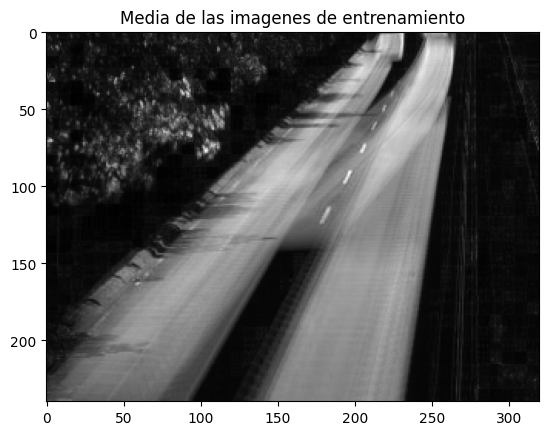

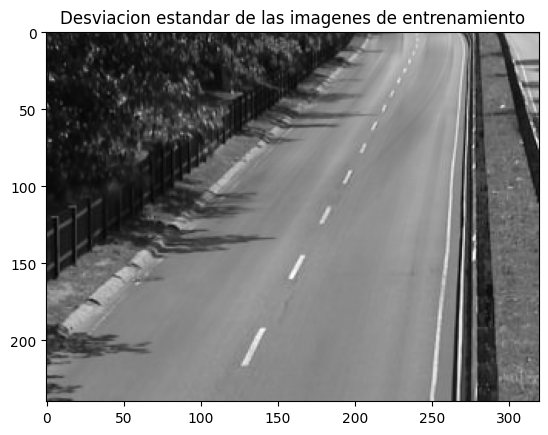

In [72]:
plt.title("Media de las imagenes de entrenamiento")
plt.imshow(std, cmap = "gray");
plt.show()
plt.title("Desviacion estandar de las imagenes de entrenamiento")
plt.imshow(mean, cmap = "gray");
plt.show()

## STATIC THRESHOLD

Predict con threshold estatico 

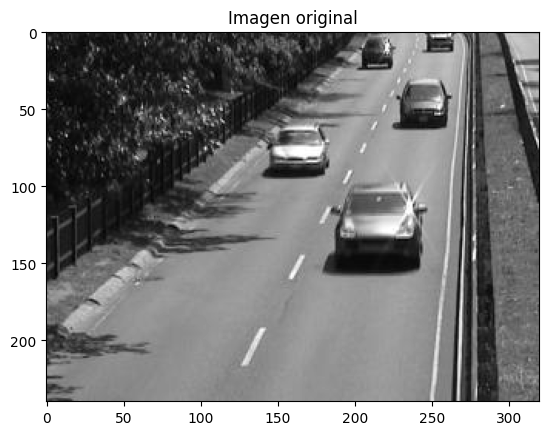

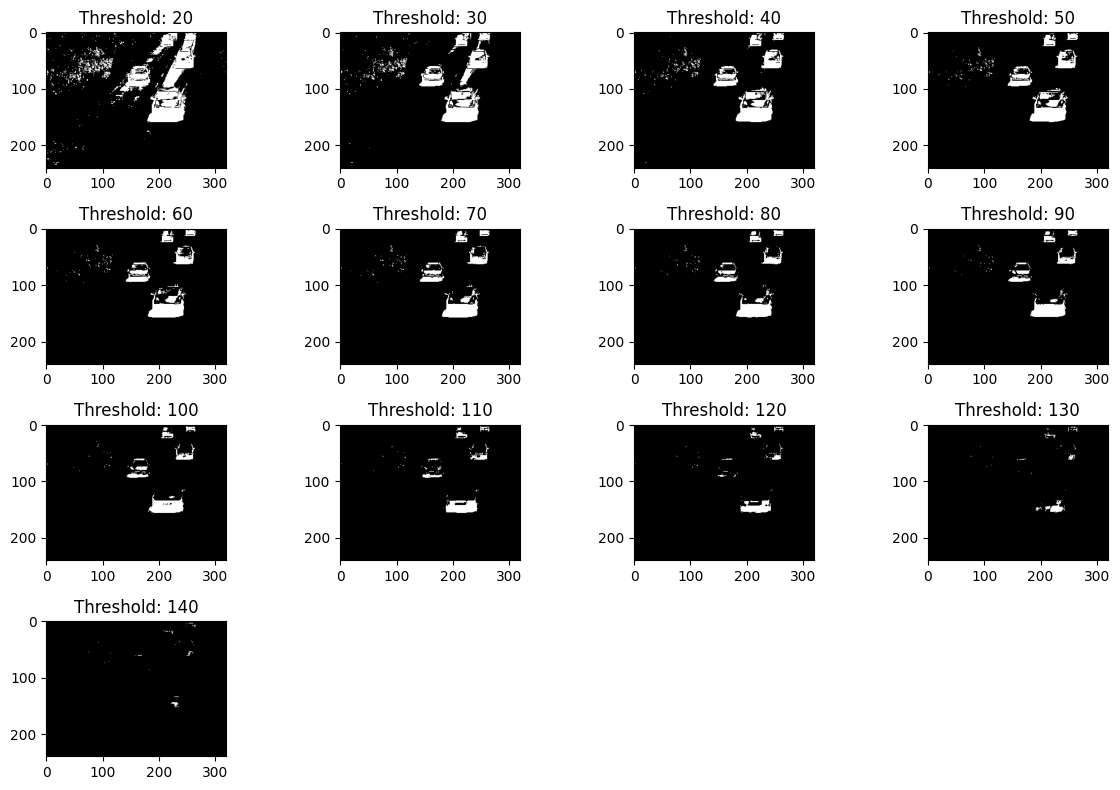

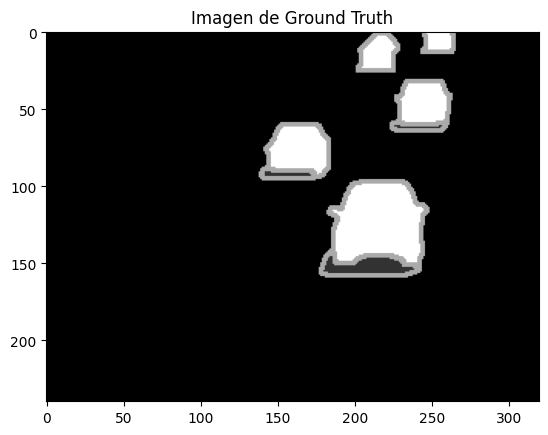

In [73]:
predict_static_threshold = []

plt.imshow(train_imgs[0], cmap='gray')
plt.title("Imagen original")
plt.show()

plt.figure(figsize=(12, 8))  # Set figure size

for i, threshold in enumerate(np.arange(20, 150, 10)):
    res = np.logical_or((train_imgs - mean) > threshold, (train_imgs - mean) < -threshold).astype(int)*255
    predict_static_threshold.append(res)
    
    plt.subplot(4, 4, i + 1)  # Create subplots in a 2x4 grid
    plt.imshow(res[0], cmap='gray')
    plt.title(f"Threshold: {threshold}")

plt.tight_layout()  # Adjust layout
plt.show()
plt.imshow(train_imgsGT[0], cmap='gray')
plt.title("Imagen de Ground Truth")
plt.show()

predict_static_threshold = np.array(predict_static_threshold)



In [35]:
def evaluate(predict, GT):
    f1 = f1_score(GT.flatten(), predict.flatten(), pos_label=255, average='weighted')
    return f1


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:56<00:00,  4.32s/it]


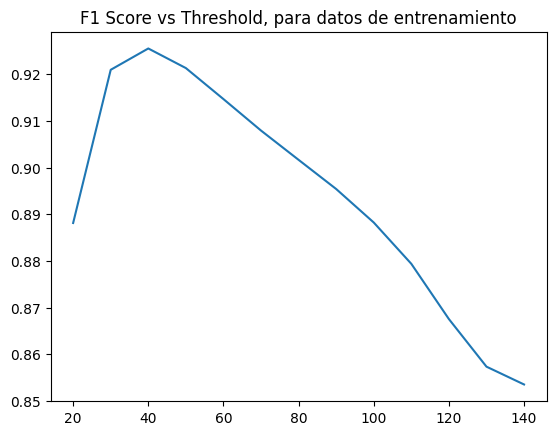

In [74]:
f1_static_threshol = [evaluate(pred, train_imgsGT) for pred in tqdm.tqdm(predict_static_threshold)]
plt.plot(np.arange(20, 150, 10), f1_static_threshol)
plt.title("F1 Score vs Threshold, para datos de entrenamiento")
plt.show()

Pasamos a testear con el threshold que maximiza el train

In [81]:
predict_static_threshold_test = np.logical_or((test_imgs - mean) > 40,( test_imgs - mean) < - 40)
evaluate(predict_static_threshold_test, test_imgsGT)

0.9328224930790601

## DYNAMIC THRESHOLD

### VERSIÓN 1

Creación de una primer modelo probando diferentes valores de alpha o beta

In [76]:
results_dynamicThreshold1 = {}
for alpha in np.arange(1, 5, 1):
    results_dynamicThreshold1[alpha] = {}
    for beta in np.arange(30,60,5):
        results_dynamicThreshold1[alpha][beta] = np.logical_or((train_imgs - mean) > alpha * std + beta, (train_imgs - mean) < -(alpha * std + beta)).astype(int) * 255

In [77]:
f1_dynamicThreshold1 = {}
for i in results_dynamicThreshold1.keys():
    print("alpha: ",i)
    f1_dynamicThreshold1[i] = {}
    for j in results_dynamicThreshold1[i].keys():
        f1 = evaluate(results_dynamicThreshold1[i][j], train_imgsGT)
        f1_dynamicThreshold1[i][j] = f1
        print("------beta: ",j, " ------", f1 )




alpha:  1
------beta:  30  ------ 0.9069170674757868
------beta:  35  ------ 0.9037964638991954
------beta:  40  ------ 0.9006329610261135
------beta:  45  ------ 0.8973409717888161
------beta:  50  ------ 0.8938531657347805
------beta:  55  ------ 0.8899628867265755
alpha:  2
------beta:  30  ------ 0.875078375734909
------beta:  35  ------ 0.8705213144537907
------beta:  40  ------ 0.8662432161781904
------beta:  45  ------ 0.8624401719681348
------beta:  50  ------ 0.8593129295771715
------beta:  55  ------ 0.856970299392299
alpha:  3
------beta:  30  ------ 0.8549250383303698
------beta:  35  ------ 0.8540561308836127
------beta:  40  ------ 0.8534538299103277
------beta:  45  ------ 0.8529998322417947
------beta:  50  ------ 0.8526583660795336
------beta:  55  ------ 0.8523775007323979
alpha:  4
------beta:  30  ------ 0.8524196724863593
------beta:  35  ------ 0.8522264806324535
------beta:  40  ------ 0.8520485849651882
------beta:  45  ------ 0.8518925360220457
------beta:  50 

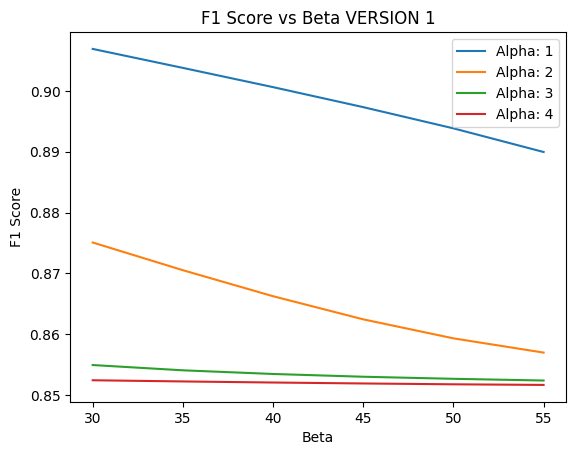

In [79]:
for i in results_dynamicThreshold1.keys():
    plt.plot(results_dynamicThreshold1[i].keys(), f1_dynamicThreshold1[i].values(), label=f"Alpha: {i}")
plt.title("F1 Score vs Beta VERSION 1")
plt.xlabel("Beta")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [103]:
max_valor = max(max(valores.values()) for valores in f1_dynamicThreshold1.values())
max_valor

0.9069170674757868

In [87]:
results_dynamicThreshold1_test = np.logical_or((test_imgs - mean) > 1 * std + 30, (test_imgs - mean) < -(1 * std + 30)).astype(int) * 255
evaluate(results_dynamicThreshold1_test, test_imgsGT)

0.9512601142376859

Como se puede observar, cuanto mas grande es alpha menor es el f1 score para cualquier valor de beta por lo tanto hay que ver como se comporta con valores de alpha mas pequeños y su reacción con los valores de beta.

### VERSIÓN 2

Ajuste de valores de alpha y beta maximizando f1 score para la clase de 255 (blanco)

In [88]:
results_dynamicThreshold2 = {}
for alpha in np.arange(0, 1.2, 0.2):
    results_dynamicThreshold2[alpha] = {}
    for beta in np.arange(20,70,10):
        results_dynamicThreshold2[alpha][beta] = np.logical_or((train_imgs - mean) > alpha * std + beta, (train_imgs - mean) < -(alpha * std + beta)).astype(int) * 255

In [89]:
results_dynamicThreshold2.keys(), results_dynamicThreshold2[0].keys()

(dict_keys([0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]),
 dict_keys([20, 30, 40, 50, 60]))

In [90]:
f1_dynamicThreshold2 = {}
for i in results_dynamicThreshold2.keys():
    print("alpha: ",i)
    f1_dynamicThreshold2[i] = {}
    for j in results_dynamicThreshold2[i].keys():
        f1 = evaluate(results_dynamicThreshold2[i][j], train_imgsGT)
        f1_dynamicThreshold2[i][j] = f1
        print("------beta: ",j, " ------", f1 )




alpha:  0.0
------beta:  20  ------ 0.888123940383158
------beta:  30  ------ 0.9209552934540047
------beta:  40  ------ 0.9255239433336424
------beta:  50  ------ 0.9213222763035444
------beta:  60  ------ 0.9146785856436519
alpha:  0.2
------beta:  20  ------ 0.9195925517807616
------beta:  30  ------ 0.9260776252883803
------beta:  40  ------ 0.9221518824531412
------beta:  50  ------ 0.9157980242080203
------beta:  60  ------ 0.9090811131623677
alpha:  0.4
------beta:  20  ------ 0.9253327648981498
------beta:  30  ------ 0.9226635195071143
------beta:  40  ------ 0.9168202906451046
------beta:  50  ------ 0.9101813600982069
------beta:  60  ------ 0.9037586269245067
alpha:  0.6000000000000001
------beta:  20  ------ 0.9223983569038967
------beta:  30  ------ 0.9176450709406951
------beta:  40  ------ 0.9112570573219209
------beta:  50  ------ 0.9048401486247243
------beta:  60  ------ 0.8984864343977713
alpha:  0.8
------beta:  20  ------ 0.9179620240935512
------beta:  30  ------

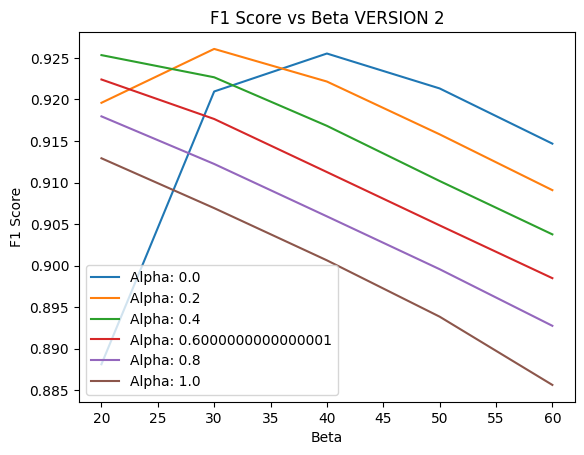

In [91]:
for i in results_dynamicThreshold2.keys():
    plt.plot(results_dynamicThreshold2[i].keys(), f1_dynamicThreshold2[i].values(), label=f"Alpha: {i}")
plt.title("F1 Score vs Beta VERSION 2")
plt.xlabel("Beta")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [101]:
max_valor = max(max(valores.values()) for valores in f1_dynamicThreshold2.values())
max_valor

0.9260776252883803

In [104]:
results_dynamicThreshold1_test = np.logical_or((test_imgs - mean) > 0.2 * std + 30, (test_imgs - mean) < -(0.2 * std + 30)).astype(int) * 255
evaluate(results_dynamicThreshold1_test, test_imgsGT)

0.9557181196379181

### VERSIÓN 3

In [94]:
results_dynamicThreshold3 = {}
for alpha in np.arange(0.0, 0.25, 0.05):
    results_dynamicThreshold3[alpha] = {}
    for beta in np.arange(20,70,10):
        results_dynamicThreshold3[alpha][beta] = np.logical_or((train_imgs - mean) > alpha * std + beta, (train_imgs - mean) < -(alpha * std + beta)).astype(int) * 255

In [95]:
f1_dynamicThreshold3 = {}
for i in results_dynamicThreshold3.keys():
    print("alpha: ",i)
    f1_dynamicThreshold3[i] = {}
    for j in results_dynamicThreshold3[i].keys():
        f1 = evaluate(results_dynamicThreshold3[i][j], train_imgsGT)
        f1_dynamicThreshold3[i][j] = f1
        print("------beta: ",j, " ------", f1 )


alpha:  0.0
------beta:  20  ------ 0.888123940383158
------beta:  30  ------ 0.9209552934540047
------beta:  40  ------ 0.9255239433336424
------beta:  50  ------ 0.9213222763035444
------beta:  60  ------ 0.9146785856436519
alpha:  0.05
------beta:  20  ------ 0.9002075829983732
------beta:  30  ------ 0.9234833331528199
------beta:  40  ------ 0.9251342634307634
------beta:  50  ------ 0.9200072161182236
------beta:  60  ------ 0.9132416644614038
alpha:  0.1
------beta:  20  ------ 0.9089281799979184
------beta:  30  ------ 0.9251615671628534
------beta:  40  ------ 0.9243768602971387
------beta:  50  ------ 0.9186299307251238
------beta:  60  ------ 0.9118193820603834
alpha:  0.15000000000000002
------beta:  20  ------ 0.9152324234646108
------beta:  30  ------ 0.9259973956951499
------beta:  40  ------ 0.9233696528388267
------beta:  50  ------ 0.9172304128585009
------beta:  60  ------ 0.9104346366888681
alpha:  0.2
------beta:  20  ------ 0.9195925517807616
------beta:  30  ----

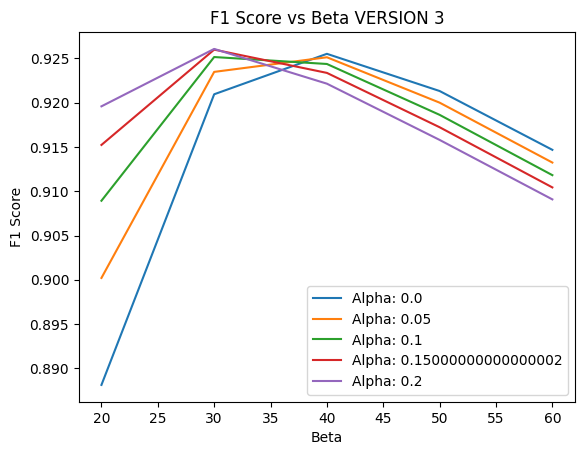

In [96]:
for i in results_dynamicThreshold3.keys():
    plt.plot(results_dynamicThreshold3[i].keys(), f1_dynamicThreshold3[i].values(), label=f"Alpha: {i}")
plt.title("F1 Score vs Beta VERSION 3")
plt.xlabel("Beta")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [100]:
max_valor = max(max(valores.values()) for valores in f1_dynamicThreshold3.values())
max_valor


0.9260776252883803

In [105]:
results_dynamicThreshold1_test = np.logical_or((test_imgs - mean) > 0.15 * std + 30, (test_imgs - mean) < -(0.15 * std + 30)).astype(int) * 255
evaluate(results_dynamicThreshold1_test, test_imgsGT)

0.9538233642171405

## Visualización de un imagen y su predicción según el modelo de threshold dinámico

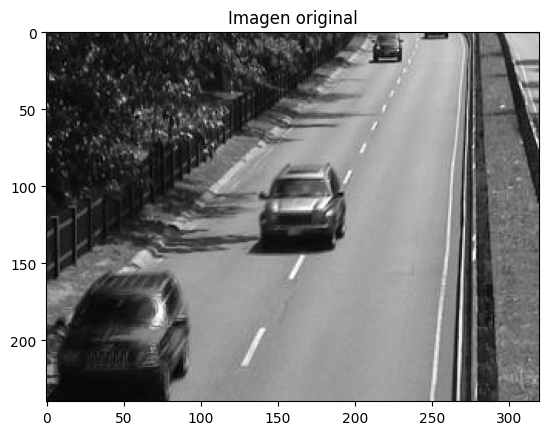

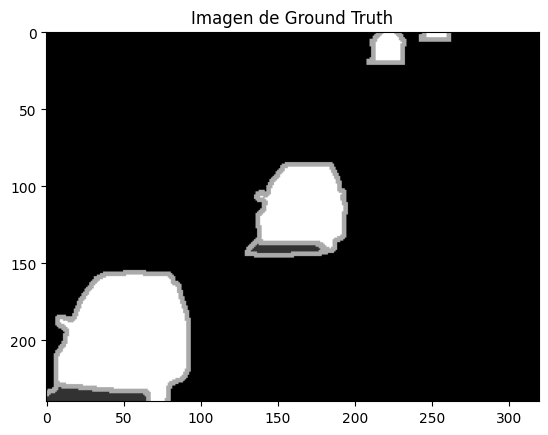

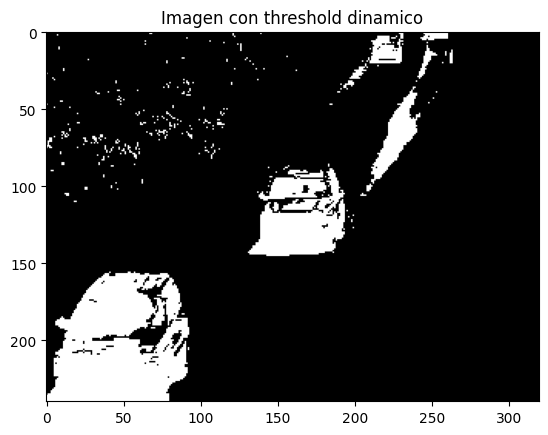

0.916717712957705

In [111]:
plt.imshow(test_imgs[0], cmap='gray')
plt.title("Imagen original")
plt.show()

plt.imshow(test_imgsGT[0], cmap='gray')
plt.title("Imagen de Ground Truth")
plt.show()

plt.imshow(results_dynamicThreshold1_test[0], cmap='gray')
plt.title("Imagen con threshold dinamico")
plt.show()


evaluate(results_dynamicThreshold1_test[0], test_imgsGT[0])

## Visualización de una imagen y su predicción con el modelo de threshold estático

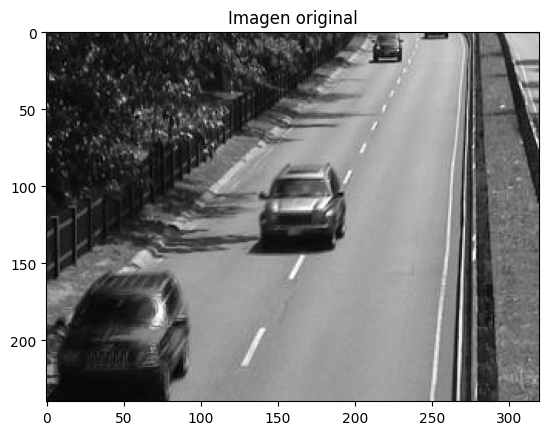

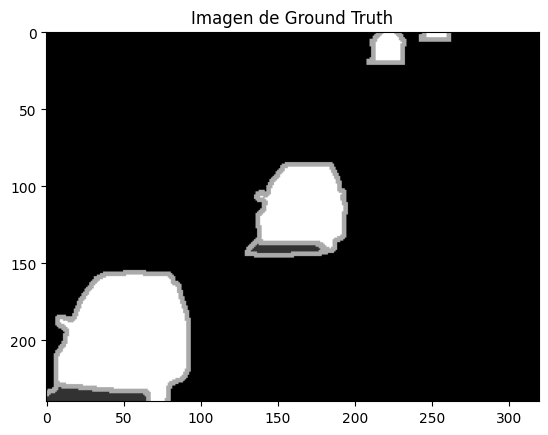

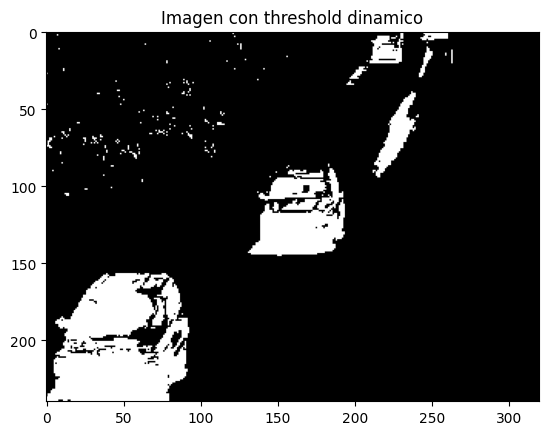

0.8413023365622541

In [112]:
plt.imshow(test_imgs[0], cmap='gray')
plt.title("Imagen original")
plt.show()

plt.imshow(test_imgsGT[0], cmap='gray')
plt.title("Imagen de Ground Truth")
plt.show()

plt.imshow(predict_static_threshold_test[0], cmap='gray')
plt.title("Imagen con threshold dinamico")
plt.show()


evaluate(predict_static_threshold_test[0], test_imgsGT[0])

## CONCLUSIONES

Hemos considerado utilizar la métrica de f1 score porque creemos que la función del modelo debe ser poder clasificar adecuadamente todos los pixeles de color blanco (representan a los coches en Ground Truth), así que no nos importa solo la precisión sino que también el recall ya que no nos valdria un modelo con alta precision y bajo recall ya que no tendriamos muchos puntos blancos en la predicción aunque esos puntos si estubieran bien clasificados, al igual que no nos valdria un modelo que tenga un recall muy bueno y una precisión muy baja ya que entonces tendriamos unas predicciones con muchos puntos blancos pero muy poca precisión de esos puntos. Nuestro modelo tiene que tener buena precision y recall un punto intermedio que maximize las dos métricas.

El modelo con threshold dinamico mejora al modelo de threshold estático, hemos creado tres modelos con threshold dinámico con la intención de ir maximizando la métrica f1-score pero no ha habido mejor notable desde el primer model de threshold dinámico, con este modelo se consigue un f1-score para la clase de 255 (blancos) de 0.9557, por lo tanto podriamos decir que es un muy buen modelo, para esta detección de coches.
